In [1]:
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import Levenshtein
import time
import librosa

from morse.models import CNNResidualBlock, TransformerResidualBlock, PoolingTransition, CNNTransformer, CTCHead
from morse.my_datasets import ListDataset, load_tensors, filenames_to_torch
from morse.samplers import LongCTCSampler
from morse.augmentations import rotation_transform
from morse.text_helpers import Vectorizer, encode_to_morse, decode_from_morse

from IPython.display import Audio

In [2]:
from morse.generators import sample_random_text, MorseGenerator

In [3]:
dev_flag = False

all_data_dir = '../data'
labels_dir = '../'

In [4]:
full_train_df = pd.read_csv(Path(labels_dir, 'train.csv'))
test_df = pd.read_csv(Path(labels_dir, 'test.csv'))
full_train_df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


In [5]:
message_lengths = pd.Series([len(m) for m in full_train_df['message']])

(array([2.000e+00, 1.300e+02, 1.298e+03, 4.109e+03, 6.885e+03, 7.426e+03,
        5.424e+03, 3.064e+03, 1.244e+03, 4.180e+02]),
 array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 <BarContainer object of 10 artists>)

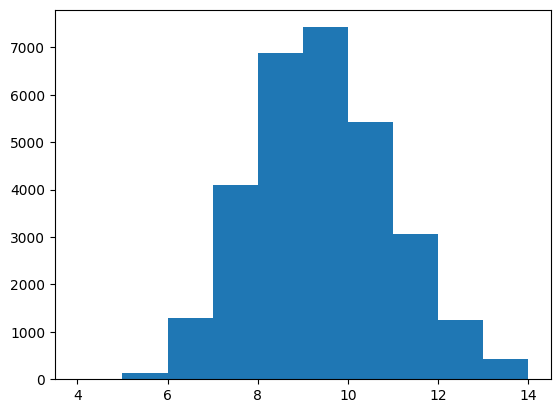

In [6]:
plt.hist(message_lengths, bins=10)

In [7]:
filepath = '../morse_dataset/1.opus'
waveform, sample_rate = torchaudio.load(filepath, normalize=True)
print(waveform.shape)
print(sample_rate)
transform = MelSpectrogram(sample_rate, n_fft=512, hop_length=512 // 4, n_mels=64)
mel_spec = transform(waveform)
mel_spec.shape

torch.Size([1, 64000])
8000


torch.Size([1, 64, 501])

In [8]:
def load_waveforms(paths: list, normalize = True, expected_sr = 8000):
    waveforms = []
    for path in tqdm(paths):
        waveform, sample_rate = torchaudio.load(path, normalize=normalize)
        if sample_rate != expected_sr:
            raise ValueError(f'wrong sample rate [{sample_rate}] instead of expected [{expected_sr}] for [{path}]')
        waveforms.append(waveform)
    return waveforms

In [9]:
waveforms = load_waveforms([f'../morse_dataset/{name}' for name in full_train_df['id']][:1000], normalize=True)

100%|██████████| 1000/1000 [00:06<00:00, 159.11it/s]


In [10]:
waveforms[0].shape

torch.Size([1, 64000])

In [11]:
composed_waveforms = torch.cat(waveforms, dim=0)

mel_specs = transform(composed_waveforms)


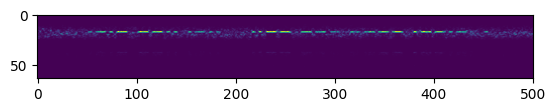

In [12]:
plt.imshow(mel_specs[9])

In [13]:
torch.max(waveforms[0]), torch.min(waveforms[0])

(tensor(1.0961), tensor(-1.0982))

In [14]:
torch.std(waveforms[3])

tensor(0.7078)

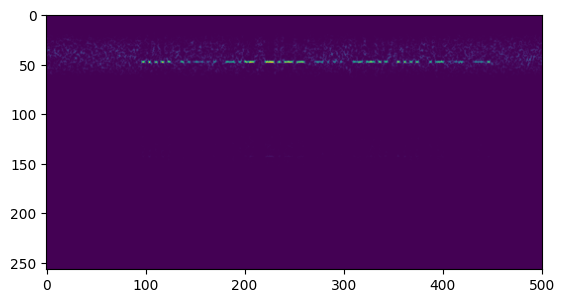

In [15]:
spectrogram_tr = torchaudio.transforms.Spectrogram(n_fft=512, hop_length=512 // 4, normalized=True)
plt.imshow(spectrogram_tr(composed_waveforms[2]))

In [16]:
# index_to_letter = sorted(set(''.join(full_train_df['message'])))
# pad_value = 0
# print(index_to_letter)
# letter_to_index = dict([(letter, i) for i, letter in enumerate(index_to_letter)])
# dictionary_size = len(index_to_letter)
# print(dictionary_size)
# print(letter_to_index)

# vectorizer = Vectorizer(letter_to_index, index_to_letter)
# print(vectorizer.text_transform('ПРИВЕТ #'))

In [17]:
# ''.join(index_to_letter)

tensor(586.5679) tensor(0.0005)
tensor(124.4804) tensor(0.0001)


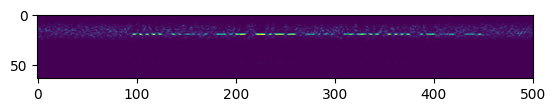

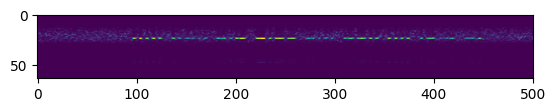

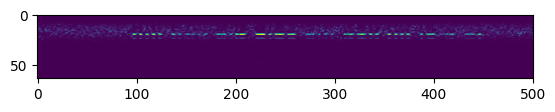

In [18]:
idx = 2
classic = torch.load(f'../data/melspec_nfft512_nc64/{idx + 1}.pt', weights_only=True)
transform = MelSpectrogram(sample_rate, n_fft=512, hop_length=512 // 4, n_mels=64, normalized=True)
new_way = transform(composed_waveforms[idx])

print(torch.max(classic), torch.min(classic))
print(torch.max(new_way), torch.min(new_way))
plt.imshow(classic)
plt.show()
plt.imshow(new_way)
plt.show()
plt.imshow(torch.abs(classic - new_way))

In [19]:
# np.linspace(0, 1, 10, endpoint=True)

In [20]:
sr = 8000
carrier_freq = 800
volume = 1.0
signal_duration = 8

torch.Size([64000])


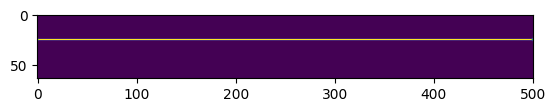

In [21]:
def generate_tone(duration: float, frequency, sr):
    t = torch.linspace(0, duration, int(duration * sr))
    return torch.sin(2 * torch.pi * frequency * t)

beep = generate_tone(duration=signal_duration, frequency=800, sr=sr)
print(beep.shape)
plt.imshow(transform(beep))
plt.show()
Audio(beep, rate=sr)

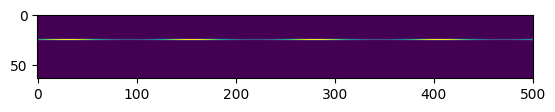

In [22]:
def volume_sinusoid_variation(signal, duration, variation_frequency: float, phase, min_residual):
    t = torch.linspace(0, duration, signal.shape[0])
    volume_multiplier = 1 * min_residual + (1 - min_residual) * (1 + torch.sin(2 * torch.pi * variation_frequency * t + phase)) / 2
    return signal * volume_multiplier

variable_beep = volume_sinusoid_variation(beep, signal_duration, variation_frequency=0.5, phase=0, min_residual=0.5)
plt.imshow(transform(variable_beep))
plt.show()
Audio(variable_beep, rate=sr)

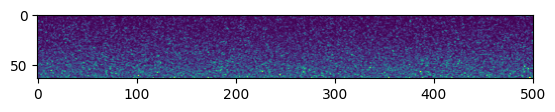

In [23]:
pure_noise = torch.randn(beep.shape[0])
plt.imshow(transform(pure_noise))
Audio(pure_noise, rate=sr)

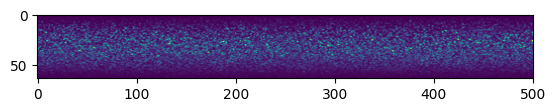

In [24]:
central_frequency = 800

filtered_noise = torchaudio.functional.bandpass_biquad(pure_noise, sample_rate=sr, 
                                                       central_freq=central_frequency,
                                                         Q=0.4)

plt.imshow(transform(filtered_noise))
Audio(filtered_noise, rate=sr)

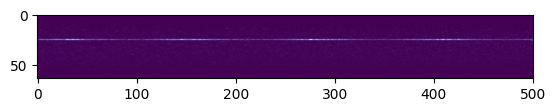

In [25]:
noisy_signal = variable_beep + filtered_noise
plt.imshow(transform(noisy_signal))
Audio(noisy_signal, rate=sr)

### real values

In [26]:
F.pad(torch.ones(3), (4, 1), value=0)

tensor([0., 0., 0., 0., 1., 1., 1., 0.])

559И4ЭЧ ЕЩВ
..... ..... ----. .. ....- ..-.. ---./. --.- .--
torch.Size([64000])
torch.Size([64000])


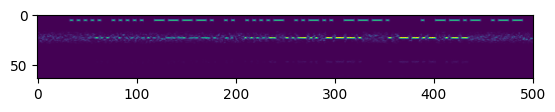

In [27]:
idx = 23
message = full_train_df['message'][idx]
morsed_message = encode_to_morse(message, remove_separator_pad=True)
print(message)
print(morsed_message)

true_signal = waveforms[idx].squeeze()
print(true_signal.shape)
out, _ = MorseGenerator(carrier_freq_range=(100, 600))._generate_pure_sample(morsed_message)
print(out.shape)
plt.imshow(transform(out + true_signal))
plt.show()

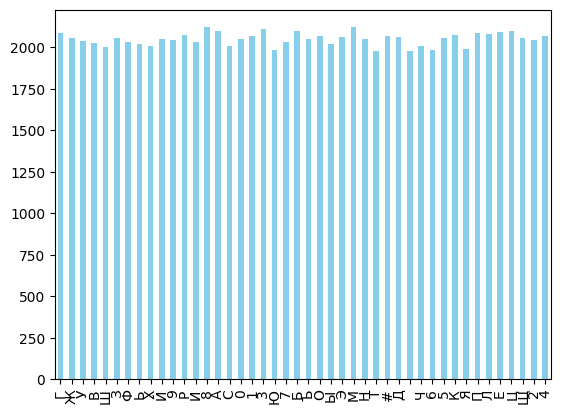

(array([1468., 1395., 1424., 1372., 1425., 1429., 1487.]),
 array([ 6.        ,  6.85714286,  7.71428571,  8.57142857,  9.42857143,
        10.28571429, 11.14285714, 12.        ]),
 <BarContainer object of 7 artists>)

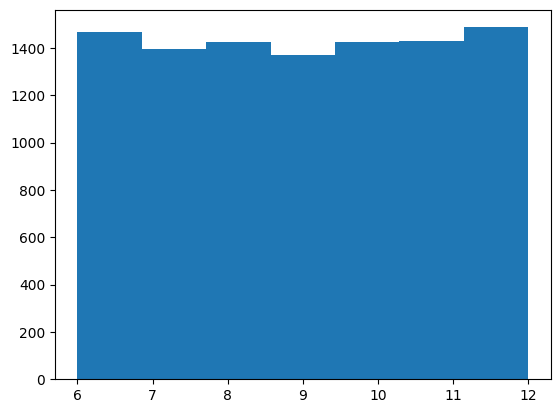

In [28]:
from collections import Counter

text_samples = [sample_random_text() for i in range(10000)]
counter = Counter(''.join(text_samples))
counts = pd.DataFrame({'Counter': counter})['Counter']
counts.plot(kind='bar', color='skyblue')
plt.show()
plt.hist([len(m) for m in text_samples], bins=7)

In [29]:
# morse_generator = MorseGenerator()

# signals, messages, frequencies = morse_generator._generate_list_of_pure_samples(10000)

# plt.hist([len(m) for m in messages], bins=7)

In [30]:
# def volume_sinusoid_variation(signal, duration, variation_frequency: float, phase, min_residual):
#     t = torch.linspace(0, duration, signal.shape[0])
#     volume_multiplier = 1 * min_residual + (1 - min_residual) * (1 + torch.sin(2 * torch.pi * variation_frequency * t + phase)) / 2
#     return signal * volume_multiplier

# # variable_beep = volume_sinusoid_variation(beep, signal_duration, variation_frequency=1, phase=0, min_residual=0.5)


# def apply_post_effects(signals: list, frequencies: list, var_freq_bounds = (0.1, 0.5)):
#     for signal, freq in zip(signals, frequencies):
#         phase = torch.rand(1).item() * torch.pi * 2
#         var_freq = torch.rand(1).item() * (var_freq_bounds[1] - var_freq_bounds[0]) + var_freq_bounds[0]
#         varied_signal = volume_sinusoid_variation(signal, )

In [31]:
samples, messages = MorseGenerator().generate(size=100)

making pure signals


100%|██████████| 100/100 [00:00<00:00, 603.35it/s]


adding noise


100%|██████████| 100/100 [00:00<00:00, 425.45it/s]


tensor(28.3940) tensor(6.9283e-07)
tensor(0.2185)
tensor(0.9915) tensor(-1.)


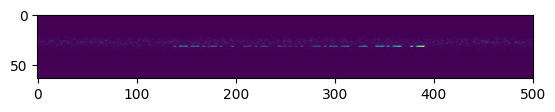

.--.-. . -.- -... -.-- - -.- .-


In [42]:
idx = 19
melspec = transform(samples[idx])
print(torch.max(melspec), torch.min(melspec))
print(torch.std(samples[idx]))
print(torch.max(samples[idx]), torch.min(samples[idx]))
plt.imshow(melspec)
plt.show()

print(encode_to_morse(messages[idx]))
Audio(samples[idx], rate=8000)